In [14]:
from sklearn.neighbors import KNeighborsRegressor
import dill as pickle
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from matplotlib import pyplot as plt
from functions.data_processing import create_set
from functions.prediction import make_predictions as p, generate_pdda_preds
from functions.visualization import posHeatmapXY, spatial_plot
from sklearn.multioutput import MultiOutputRegressor
from sklearn import svm

import warnings
warnings.filterwarnings("ignore")

In [2]:
with open("data.pkl", "rb") as pkl_handle:
    data = pickle.load(pkl_handle)

In [3]:
points = pd.read_pickle('points.pkl')

In [4]:
rooms = ['testbench_01', 'testbench_01_furniture_low', 'testbench_01_furniture_mid', 'testbench_01_furniture_high']
concrete_rooms = ['testbench_01_furniture_low_concrete', 'testbench_01_furniture_mid_concrete', 'testbench_01_furniture_high_concrete']
other_scenarios = ['testbench_01_rotated_anchors']
anchors = ['anchor1', 'anchor2', 'anchor3', 'anchor4']
channels = ['37','38','39']
polarities = ['V','H']

In [15]:
regr = MultiOutputRegressor(svm.SVR())

In [17]:
svm_model = {}

In [ ]:
# fix environment, pick the one with concrete

Training Set: 80
Test Set: 40


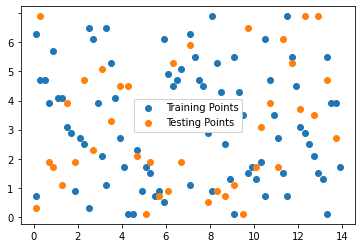

Training Set: 80
Test Set: 40


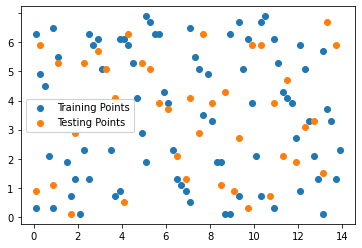

Training Set: 80
Test Set: 40


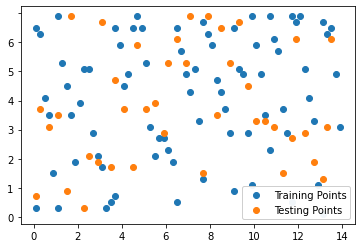

In [18]:
kf = KFold(n_splits=3, shuffle=True)
models_dict = {}
split = 0
for train_index, test_index in kf.split(points):
    split += 1
    train_points = points.iloc[train_index]
    train_points  = train_points.sort_values(['x_tag', 'y_tag'])
    train_points = train_points.iloc[::20, :]
    
    test_points = points.iloc[test_index]
    test_points  = test_points.sort_values(['x_tag', 'y_tag'])
    test_points = test_points.iloc[::20, :]
    print('Training Set: '+ str(len(train_points)))
    print('Test Set: ' + str(len(test_points)))
    
    plt.scatter(train_points.iloc[:,1:2].values,train_points.iloc[:,2:3].values)
    plt.scatter(test_points.iloc[:,1:2].values,test_points.iloc[:,2:3].values)
    plt.legend(['Training Points', 'Testing Points'], framealpha=0.94, fancybox=True)
    ax = plt.gca()
    ax.set_xticklabels(range(-2,15,2))
    ax.set_yticklabels(range(-1,7,1))
    plt.show()
    
#     #creat train/test sets
    x_train, y_train = create_set(data, rooms, train_points, augmentation=True)                       
    x_test, y_test = create_set(data, rooms + concrete_rooms + other_scenarios, test_points)
    for training_room in rooms:
        key = training_room
        if training_room not in svm_model.items():
            svm_model[key] = regr
        
        ytrain = pd.concat([y_train[training_room][anchor]['37'] for anchor in anchors], axis=1)
        xtrain = pd.concat([x_train[training_room][anchor]['37'] for anchor in anchors], axis=1)
        ytest = pd.concat([y_test[training_room][anchor]['37'] for anchor in anchors], axis=1)
        xtest = pd.concat([x_test[training_room][anchor]['37'] for anchor in anchors], axis=1)
        svm_model[key].fit(xtrain, ytrain)

        models_dict[str(split)] = svm_model

In [27]:
from collections import defaultdict
from sklearn.metrics import mean_absolute_error
from functions.prediction import lsq
def make_predictions(df_x, df_y, model, training_rooms, testing_rooms, test_points = None,
                    anchor_data = None, cnn = False):

    """
    Input: x, y
    Output: predictions and errors
    """

    angle_maes = defaultdict(lambda: (np.empty((2,4,10))))
    pos_maes = np.zeros((4,10))

    if cnn:
        y_test = pd.concat([df_y['testbench_01'][anchor] for anchor in anchors], axis=1)
    else:
        y_test = pd.concat([df_y['testbench_01'][anchor]['37'] for anchor in anchors], axis=1)

    angle_preds = defaultdict(dict)
    pos_angle_preds = defaultdict(dict)
    for i,training in enumerate(training_rooms):
        for j,testing in enumerate(testing_rooms):
            pos_preds = {}
            xtest = df_x[testing]
            xtest = pd.concat([x_test[training_room][anchor]['37'] for anchor in anchors], axis=1)
            angle_preds[training][testing] = model[training].predict(xtest)
            angle_preds_mae_angles = mean_absolute_error(angle_preds[training][testing], y_test,  multioutput='raw_values')

            for k,anchor in enumerate(anchors):
                angle_maes[anchor][:,i,j] = angle_preds_mae_angles[(2*k):(2*k + 2)]
                pos_preds[anchor] = angle_preds[training][testing][:,(k*2):(k*2 + 2)]
                
            pos_angle_preds[training][testing] = np.array(lsq(pos_preds, anchor_data[testing][anchors[0]]['37']['H']))
            true_pos = test_points[['x_tag', 'y_tag', 'z_tag']].values

            pos_maes[i,j] = np.mean(np.sqrt(np.sum((true_pos[:,:2] - pos_angle_preds[training][testing][:,:2])**2, axis=1)))
    
    predictions = {"angle_maes": angle_maes,
                   "pos_maes": pos_maes,
                   "angle_preds": angle_preds,
                   "pos_preds": pos_angle_preds
                   }
    
    return predictions, true_pos


In [20]:

with open("anchor_data.pkl", "rb") as pkl_handle:
    anchor_data = pickle.load(pkl_handle)

In [28]:
for k,v in models_dict.items():
    # print(v['testbench_01'])
    preds, true = make_predictions(x_test, y_test, v, training_rooms=rooms, testing_rooms=rooms + concrete_rooms + other_scenarios, 
                               test_points=test_points, anchor_data=anchor_data)

In [29]:
#produce pdda predictions
pdda_res = generate_pdda_preds(data, rooms + concrete_rooms + other_scenarios, test_points, anchor_data)

In [53]:
mae = 0
for k,v in models_dict.items():
    mae += mean_absolute_error(models_dict[k]['testbench_01'].predict(xtest), ytest)
mae /= 3
mae

5.475999275601612